In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import nltk
import future
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from bs4 import BeautifulSoup  
import re
import nltk
from nltk.corpus import stopwords 

In [4]:
data = pd.read_csv("/content/drive/MyDrive/data/Mobile_up.csv", encoding='latin1')
data.head()

,Unnamed: 0,Product Name,Brand,Reviews,Rating,Lemma,Polarity,Analysis,Label
0,0,Apple iPhone 12 Pro Max (256GB) - Pacific Blue,Apple,Just excellent,5,excellent,1.0,Positive,1
1,1,Apple iPhone 12 Pro Max (256GB) - Pacific Blue,Apple,Currently the best phone Apple makes,5,Currently best phone Apple make,1.0,Positive,1
2,2,Apple iPhone 12 Pro Max (256GB) - Pacific Blue,Apple,This took one of my kidneys and a testicle. Bu...,5,take one kidney testicle worth,0.3,Positive,1
3,4,Apple iPhone 12 (128GB) - Blue,Apple,Best Premium Smartphone in all aspects,5,Best Premium Smartphone aspect,1.0,Positive,1
4,5,Apple iPhone 12 (128GB) - Blue,Apple,Best iPhone,5,Best iPhone,1.0,Positive,1


In [5]:
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data.head()

,Product Name,Brand,Reviews,Rating,Lemma,Polarity,Analysis,Label
0,Apple iPhone 12 Pro Max (256GB) - Pacific Blue,Apple,Just excellent,5,excellent,1.0,Positive,1
1,Apple iPhone 12 Pro Max (256GB) - Pacific Blue,Apple,Currently the best phone Apple makes,5,Currently best phone Apple make,1.0,Positive,1
2,Apple iPhone 12 Pro Max (256GB) - Pacific Blue,Apple,This took one of my kidneys and a testicle. Bu...,5,take one kidney testicle worth,0.3,Positive,1
3,Apple iPhone 12 (128GB) - Blue,Apple,Best Premium Smartphone in all aspects,5,Best Premium Smartphone aspect,1.0,Positive,1
4,Apple iPhone 12 (128GB) - Blue,Apple,Best iPhone,5,Best iPhone,1.0,Positive,1


In [6]:
mydata = data
mydata.head()

,Product Name,Brand,Reviews,Rating,Lemma,Polarity,Analysis,Label
0,Apple iPhone 12 Pro Max (256GB) - Pacific Blue,Apple,Just excellent,5,excellent,1.0,Positive,1
1,Apple iPhone 12 Pro Max (256GB) - Pacific Blue,Apple,Currently the best phone Apple makes,5,Currently best phone Apple make,1.0,Positive,1
2,Apple iPhone 12 Pro Max (256GB) - Pacific Blue,Apple,This took one of my kidneys and a testicle. Bu...,5,take one kidney testicle worth,0.3,Positive,1
3,Apple iPhone 12 (128GB) - Blue,Apple,Best Premium Smartphone in all aspects,5,Best Premium Smartphone aspect,1.0,Positive,1
4,Apple iPhone 12 (128GB) - Blue,Apple,Best iPhone,5,Best iPhone,1.0,Positive,1


In [7]:
mydata.shape

(99442, 8)

In [8]:
mydata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99442 entries, 0 to 99441
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Product Name  99442 non-null  object 
 1   Brand         99442 non-null  object 
 2   Reviews       99442 non-null  object 
 3   Rating        99442 non-null  int64  
 4   Lemma         99442 non-null  object 
 5   Polarity      99442 non-null  float64
 6   Analysis      99442 non-null  object 
 7   Label         99442 non-null  int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 6.1+ MB


#Data Preprocessing

###Missing Values Imputation

In [9]:
# Let's see which number of rows consist missing values for 'Reviews' column 
mydata[mydata['Reviews'].isnull()]

,Product Name,Brand,Reviews,Rating,Lemma,Polarity,Analysis,Label


### Cleaning Text

In [10]:
# Define a function to clean the text
import re
def clean(text):
# Removes all special characters and numericals leaving the alphabets
    text = re.sub('[^A-Za-z]+', ' ', str(text))
    return text

# Cleaning the text in the review column
mydata['Cleaned Reviews'] = mydata['Reviews'].apply(clean)
mydata.head()

,Product Name,Brand,Reviews,Rating,Lemma,Polarity,Analysis,Label,Cleaned Reviews
0,Apple iPhone 12 Pro Max (256GB) - Pacific Blue,Apple,Just excellent,5,excellent,1.0,Positive,1,Just excellent
1,Apple iPhone 12 Pro Max (256GB) - Pacific Blue,Apple,Currently the best phone Apple makes,5,Currently best phone Apple make,1.0,Positive,1,Currently the best phone Apple makes
2,Apple iPhone 12 Pro Max (256GB) - Pacific Blue,Apple,This took one of my kidneys and a testicle. Bu...,5,take one kidney testicle worth,0.3,Positive,1,This took one of my kidneys and a testicle But...
3,Apple iPhone 12 (128GB) - Blue,Apple,Best Premium Smartphone in all aspects,5,Best Premium Smartphone aspect,1.0,Positive,1,Best Premium Smartphone in all aspects
4,Apple iPhone 12 (128GB) - Blue,Apple,Best iPhone,5,Best iPhone,1.0,Positive,1,Best iPhone


### Tokenize, Stop-words, pos 

In [11]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.corpus import wordnet

# POS tagger dictionary
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
        
    return newlist

mydata['POS tagged'] = mydata['Cleaned Reviews'].apply(token_stop_pos)
mydata.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,Product Name,Brand,Reviews,Rating,Lemma,Polarity,Analysis,Label,Cleaned Reviews,POS tagged
0,Apple iPhone 12 Pro Max (256GB) - Pacific Blue,Apple,Just excellent,5,excellent,1.0,Positive,1,Just excellent,"[(excellent, n)]"
1,Apple iPhone 12 Pro Max (256GB) - Pacific Blue,Apple,Currently the best phone Apple makes,5,Currently best phone Apple make,1.0,Positive,1,Currently the best phone Apple makes,"[(Currently, r), (best, a), (phone, n), (Apple..."
2,Apple iPhone 12 Pro Max (256GB) - Pacific Blue,Apple,This took one of my kidneys and a testicle. Bu...,5,take one kidney testicle worth,0.3,Positive,1,This took one of my kidneys and a testicle But...,"[(took, v), (one, None), (kidneys, n), (testic..."
3,Apple iPhone 12 (128GB) - Blue,Apple,Best Premium Smartphone in all aspects,5,Best Premium Smartphone aspect,1.0,Positive,1,Best Premium Smartphone in all aspects,"[(Best, n), (Premium, n), (Smartphone, n), (as..."
4,Apple iPhone 12 (128GB) - Blue,Apple,Best iPhone,5,Best iPhone,1.0,Positive,1,Best iPhone,"[(Best, n), (iPhone, n)]"


# Obtaining the stem words – Lemmatization

In [12]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
        if not pos:
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + " " + lemma
    return lemma_rew

mydata['Lemma'] = mydata['POS tagged'].apply(lemmatize)
mydata.head()

,Product Name,Brand,Reviews,Rating,Lemma,Polarity,Analysis,Label,Cleaned Reviews,POS tagged
0,Apple iPhone 12 Pro Max (256GB) - Pacific Blue,Apple,Just excellent,5,excellent,1.0,Positive,1,Just excellent,"[(excellent, n)]"
1,Apple iPhone 12 Pro Max (256GB) - Pacific Blue,Apple,Currently the best phone Apple makes,5,Currently best phone Apple make,1.0,Positive,1,Currently the best phone Apple makes,"[(Currently, r), (best, a), (phone, n), (Apple..."
2,Apple iPhone 12 Pro Max (256GB) - Pacific Blue,Apple,This took one of my kidneys and a testicle. Bu...,5,take one kidney testicle worth,0.3,Positive,1,This took one of my kidneys and a testicle But...,"[(took, v), (one, None), (kidneys, n), (testic..."
3,Apple iPhone 12 (128GB) - Blue,Apple,Best Premium Smartphone in all aspects,5,Best Premium Smartphone aspect,1.0,Positive,1,Best Premium Smartphone in all aspects,"[(Best, n), (Premium, n), (Smartphone, n), (as..."
4,Apple iPhone 12 (128GB) - Blue,Apple,Best iPhone,5,Best iPhone,1.0,Positive,1,Best iPhone,"[(Best, n), (iPhone, n)]"


In [13]:
mydata[['Reviews','Lemma']]

,Reviews,Lemma
0,Just excellent,excellent
1,Currently the best phone Apple makes,Currently best phone Apple make
2,This took one of my kidneys and a testicle. Bu...,take one kidney testicle worth
3,Best Premium Smartphone in all aspects,Best Premium Smartphone aspect
4,Best iPhone,Best iPhone
...,...,...
99437,Stopped turning on within 3 days. With no warr...,Stopped turn within day warranty royally f e...
99438,Came as expected,Came expect
99439,Bad. Azz. Phone.,Bad Azz Phone
99440,"Love the phone, great screen, fast, slim but d...",Love phone great screen fast slim dislike Mo...


### Look at the Lemma text using wordcloud 

In [14]:
! pip install wordcloud

In [15]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS

In [16]:
# Create a new data frame 'reviewss' to perform exploratory data analysis on that
reviewss = mydata
# dropping null values
reviewss.dropna(inplace = True)

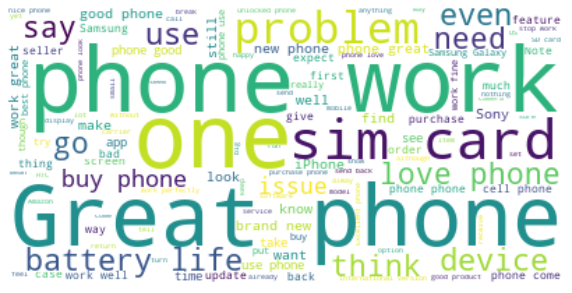

In [17]:
# wordcloud function's need to be a single string of text
# concatenating all reviews in a single string
reviewss_str = reviewss.Lemma.str.cat()
wordcloud = WordCloud(background_color='white').generate(reviewss_str)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.show()

# Sentiment Analysis using TextBlob:

In [18]:
from textblob import TextBlob
# function to calculate subjectivity
def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity
    # function to calculate polarity
def getPolarity(review):
    return TextBlob(review).sentiment.polarity

i = -1
# function to analyze the reviews
def analysis(score):
    global i
    i = i+1
    if score > 0 and fin_data['Rating'][i] >3:
      return 'Positive'
    elif score == 0 and fin_data['Rating'][i] == 3:
      return 'Neutral'             
    else:
      return 'Negative'


        

In [19]:
fin_data = pd.DataFrame(mydata[['Brand','Reviews','Rating','Lemma']])

In [20]:
# fin_data['Subjectivity'] = fin_data['Lemma'].apply(getSubjectivity) 
fin_data['Polarity'] = fin_data['Lemma'].apply(getPolarity) 
fin_data['Analysis'] = fin_data['Polarity'].apply(analysis)
fin_data.head()

,Brand,Reviews,Rating,Lemma,Polarity,Analysis
0,Apple,Just excellent,5,excellent,1.0,Positive
1,Apple,Currently the best phone Apple makes,5,Currently best phone Apple make,1.0,Positive
2,Apple,This took one of my kidneys and a testicle. Bu...,5,take one kidney testicle worth,0.3,Positive
3,Apple,Best Premium Smartphone in all aspects,5,Best Premium Smartphone aspect,1.0,Positive
4,Apple,Best iPhone,5,Best iPhone,1.0,Positive


Removing Neutral Values


In [21]:
fin_data = fin_data[fin_data.Analysis != 'Neutral']

### Count the number of positive, negative, neutral reviews. 

In [22]:
tb_counts = fin_data.Analysis.value_counts()
tb_counts

Positive    49721
Negative    49721
Name: Analysis, dtype: int64

In [23]:
tb_apple_counts = fin_data[(fin_data.Brand)=='Apple'].Analysis.value_counts()
tb_apple_counts

Positive    19948
Negative    18590
Name: Analysis, dtype: int64

In [24]:
tb_samsung_counts = fin_data[(fin_data.Brand)=='Samsung'].Analysis.value_counts()
tb_samsung_counts

Negative    20617
Positive    18156
Name: Analysis, dtype: int64

In [25]:
tb_htc_counts = fin_data[(fin_data.Brand)=='HTC'].Analysis.value_counts()
tb_htc_counts

Negative    3646
Positive    2773
Name: Analysis, dtype: int64

In [26]:
tb_sony_counts = fin_data[(fin_data.Brand)=='Sony'].Analysis.value_counts()
tb_sony_counts

Positive    5360
Negative    4318
Name: Analysis, dtype: int64

In [27]:
fin_data[(fin_data.Brand)=='Huawei'].Analysis.value_counts()

Positive    2933
Negative    1363
Name: Analysis, dtype: int64

In [28]:
fin_data[(fin_data.Brand)=='Asus'].Analysis.value_counts()

Negative    914
Positive    452
Name: Analysis, dtype: int64

In [29]:
fin_data.head()

,Brand,Reviews,Rating,Lemma,Polarity,Analysis
0,Apple,Just excellent,5,excellent,1.0,Positive
1,Apple,Currently the best phone Apple makes,5,Currently best phone Apple make,1.0,Positive
2,Apple,This took one of my kidneys and a testicle. Bu...,5,take one kidney testicle worth,0.3,Positive
3,Apple,Best Premium Smartphone in all aspects,5,Best Premium Smartphone aspect,1.0,Positive
4,Apple,Best iPhone,5,Best iPhone,1.0,Positive


In [30]:
labels = []
for cell in fin_data['Analysis']:
  if cell == 'Positive':
    labels.append('1')    
  else:
    labels.append('0')   

fin_data['Label'] = labels
            
     
        
            
      
    

In [31]:
fin_data.head()

,Brand,Reviews,Rating,Lemma,Polarity,Analysis,Label
0,Apple,Just excellent,5,excellent,1.0,Positive,1
1,Apple,Currently the best phone Apple makes,5,Currently best phone Apple make,1.0,Positive,1
2,Apple,This took one of my kidneys and a testicle. Bu...,5,take one kidney testicle worth,0.3,Positive,1
3,Apple,Best Premium Smartphone in all aspects,5,Best Premium Smartphone aspect,1.0,Positive,1
4,Apple,Best iPhone,5,Best iPhone,1.0,Positive,1


In [32]:
from sklearn.model_selection import train_test_split
#split data into training and testing set
x_train, x_test, y_train, y_test = train_test_split(fin_data['Lemma'], fin_data['Label'], test_size=0.2, random_state=0)

#CountVectorizer with Mulinomial Naive Bayes (Benchmark Model)

####Now we have cleaned reviews, the next step is to convert the reviews into numerical representations for machine learning algorithm.

In sklearn library, we can use CountVectorizer which implements both tokenization and occurrence counting in a single class. The output is a sparse matrix representation of a document.

In [33]:
# Fit and transform the training data to a document-term matrix using CountVectorizer
countVect = CountVectorizer() 
x_train_countVect = countVect.fit_transform(x_train)
print ("Number of features : %d \n" %len(countVect.get_feature_names())) 
print ("Show some feature names : \n", countVect.get_feature_names()[::1000])

Number of features : 21426 

Show some feature names : 
 ['aa', 'apperently', 'bigness', 'certify', 'coool', 'devices', 'enamorado', 'fee', 'god', 'hui', 'java', 'lunchtime', 'muihahahaha', 'oswaldo', 'polycarb', 'realabilityiam', 'rough', 'sketchy', 'substance', 'tldr', 'upload', 'wnot']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [34]:
# Train MultinomialNB classifier
mnb = MultinomialNB()
mnb.fit(x_train_countVect, y_train)

MultinomialNB()

In [35]:
# Evaluate the model on validaton set
predictions = mnb.predict(countVect.transform(x_test))
accuracy_score(y_test, predictions)
print(accuracy_score(y_test, predictions))


0.8605761978983357


#TfidfVectorizer with Logistic Regression
###Some words might frequently appear but have little meaningful information about the sentiment of a particular review. Instead of using occurance counting, we can use tf-idf transform to scale down the impact of frequently appeared words in a given corpus.

In sklearn library, we can use TfidfVectorizer which implements both tokenization and tf-idf weighted counting in a single class.

In [36]:
# Fit and transform the training data to a document-term matrix using TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5) 
x_train_tfidf = tfidf.fit_transform(x_train)
print ("Number of features : %d \n" %len(tfidf.get_feature_names()))
print ("Show some feature names : \n", tfidf.get_feature_names()[::1000])

# Logistic Regression
lr = LogisticRegression()
lr.fit(x_train_tfidf, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Number of features : 7074 

Show some feature names : 
 ['aa', 'chat', 'enhancement', 'human', 'movement', 'recommend', 'suit', 'wow']


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [37]:
 # Look at the top 10 features with smallest and the largest coefficients
feature_names = np.array(tfidf.get_feature_names())
sorted_coef_index = lr.coef_[0].argsort()
print ("Total number of features = " + str(len(sorted_coef_index)))
print ('\nTop 10 features with smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print ('Top 10 features with largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Total number of features = 7074

Top 10 features with smallest coefficients :
['disappointed' 'return' 'bad' 'terrible' 'waste' 'shut' 'unable' 'freeze'
 'horrible' 'worst']

Top 10 features with largest coefficients : 
['love' 'excellent' 'great' 'best' 'perfect' 'awesome' 'perfectly'
 'amazing' 'nice' 'exactly']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [38]:
# Evaluate on the validaton set
predictions = lr.predict(tfidf.transform(x_test))
accuracy_score(y_test, predictions)
print(accuracy_score(y_test, predictions))

0.9253356126502087


#SVM and Trees
###system will use two algorithms SVM and Random Forest to perform analysis and to determine which suits better for recommendation.

#Support Vector Machine
####Here we implement multi-svm for sentiment analysis. More information about it can be found on this link.

Tip 1 : Here, different kernels can be tried out. For example, linear, nonlinear, precomputed, rbf etc.
Tip 2 : The parameter values given below can be tweaked to obtain different results.

##Using LinearSVC
#####Here you can tweak the api parameters of LinearSVC as per your choice. Refer to this link for making any changes.

In [39]:
#x_train_subset = tfidf.transform(x_train_cleaned[:100])
x_train_input = tfidf.transform(x_train)
svr_lin = LinearSVC(multi_class='ovr',C=1.0,loss='squared_hinge', dual=False)
svr_lin.fit(x_train_input, y_train)
y_svr_lin_predicted = svr_lin.predict(tfidf.transform(x_test))

In [40]:
accuracy_score(y_test, y_svr_lin_predicted)
print(accuracy_score(y_test, y_svr_lin_predicted))


0.932073005178742


##Functions for Model Evaluation
####There are multiple functions for model evaluation in scikit learn. To know more about them, please follow the below mentioned links

* accuracy score
*f_score
*f1_score
* confusion matrix

In [41]:
print ("Accuracy of this SVM = " + str(metrics.accuracy_score(y_test, y_svr_lin_predicted)))
print ("Fscore of this SVM = " + str(metrics.precision_recall_fscore_support(y_test, y_svr_lin_predicted, pos_label=2, average='weighted')))
print ("F-1 score of this SVM = " + str(metrics.f1_score(y_test, y_svr_lin_predicted, pos_label=2, average='weighted')))
print ("confusion matrix = " + str(metrics.confusion_matrix(y_test, y_svr_lin_predicted)))

Accuracy of this SVM = 0.932073005178742
Fscore of this SVM = (0.9320874246404091, 0.932073005178742, 0.9320720122795956, None)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 2) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 2) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


F-1 score of this SVM = 0.9320720122795956
confusion matrix = [[9318  646]
 [ 705 9220]]


###Random Forest
####Refer to this link for more information

In [42]:
rand = RandomForestClassifier()
rand.fit(x_train_input, y_train)
y_rand_predicted = rand.predict(tfidf.transform(x_test))

In [43]:
y_rand_predicted

array(['0', '0', '0', ..., '1', '1', '1'], dtype=object)

In [44]:
y_rand_predicted = rand.predict(tfidf.transform(x_test))
accuracy_score(y_test, y_rand_predicted)
print(accuracy_score(y_test, y_rand_predicted))

0.9652068982854844


In [45]:
print ("Accuracy of Random Forest = " + str(rand.score(tfidf.transform(x_test), y_test)))
print ("Fscore of this SVM = " + str(metrics.precision_recall_fscore_support(y_test, y_rand_predicted, pos_label=2, average='weighted')))
print ("F-1 score of this SVM = " + str(metrics.f1_score(y_test, y_rand_predicted, pos_label=2, average='weighted')))
print ("confusion matrix = " + str(metrics.confusion_matrix(y_test, y_rand_predicted)))

Accuracy of Random Forest = 0.9652068982854844
Fscore of this SVM = (0.9653376928129839, 0.9652068982854844, 0.9652050439138801, None)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 2) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 2) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


F-1 score of this SVM = 0.9652050439138801
confusion matrix = [[9535  429]
 [ 263 9662]]


##Decision Tree

In [46]:
decTree = DecisionTreeClassifier()
decTree.fit(x_train_input, y_train)
y_decTree_predicted = decTree.predict(tfidf.transform(x_test))

In [47]:
accuracy_score(y_test, y_decTree_predicted)
print(accuracy_score(y_test, y_decTree_predicted))

0.9514304389360954


In [48]:
print ("Accuracy of Decision Tree = " + str(decTree.score(tfidf.transform(x_test), y_test)))
print ("Fscore of this SVM = " + str(metrics.precision_recall_fscore_support(y_test, y_decTree_predicted, pos_label=2, average='weighted')))
print ("F-1 score of this SVM = " + str(metrics.f1_score(y_test, y_decTree_predicted, pos_label=2, average='weighted')))
print ("confusion matrix = " + str(metrics.confusion_matrix(y_test, y_decTree_predicted)))

Accuracy of Decision Tree = 0.9514304389360954
Fscore of this SVM = (0.9517861302912538, 0.9514304389360954, 0.951422279809022, None)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 2) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 2) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


F-1 score of this SVM = 0.951422279809022
confusion matrix = [[9342  622]
 [ 344 9581]]
